# <font color="purple">**Licenciatura en Tecnologías para la Información en Ciencias**</font>

## <font color="blue">**Procesamiento Digital de Imágenes**</font>

### <font color="blue">**Tareas 5: Filtrado en la frecuencia**</font>

### Angélica Nayeli Rivas Bedolla:    418128734

### Semestre 2021-1

### Jueves 07 de enero de 2021

# Introducción

El tipo de ruido trabajado en esta tarea, que no está presente en la vida real, es llamado ruido periódico porque tiene características de periodo. Este tipo de ruido puede ser disminuído hasta ser casi imperceptible usando la Transformada de Fourier, ya que es una herramienta muy poderosa que es capaz de percibir estos patrones difíciles de detectar con las otras herramientas antes vistas en clase.
Tomando en cuenta que cualquier función puede ser aproximada con la Serie de Fourier (suma infinita de combinaciones de senos y cosenos) hace que este tipo de ruido esté presente en la Transformada de Fourier, y, al encontrarse estas irregularidades en el dominio de la frecuencia, ya solo se quitan de la imagen transformada para que al volver con la imagen original ya no haya ruido.


# Enunciado del problema

Con apoyo del espectro de Fourier 2D, realizar un filtrado en el dominio de la frecuencia, desarrollar un programa que elimine ruido periódico de las imágenes {1,..,5} anexadas a esta tarea.


# Código fuente

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from copy import copy

## Funciones

In [2]:
def PrepararImagen(nombre_imagen):
    """
    Carga la imagen con OpenCV y la convierte a escala de grises, flotante de 64 bits y escalada a 512x512.
    Recibe:
        nombre_imagen: ruta de la imagen a cargar.
    Devuelve:
        fxy: imagen procesada.
    """
    fxy = cv2.imread(nombre_imagen)
    # Filas y columnas múltiplos de 2
    numFilas = 512
    numCols = 512
    # Escalar la imagen a múltiplos de 2
    fxy = cv2.resize(fxy, (numCols, numFilas))
    # Convertir a escala de grises
    fxy_gris = cv2.cvtColor(fxy, cv2.COLOR_BGR2GRAY)
    # Punto flotante para la FT
    fxy_gris_f64 = np.float64(fxy_gris)
    return fxy_gris_f64

In [3]:
def GraficarFourierShift(img):
    figure(figsize=(5, 5))
    Fuv1 = np.fft.fft2(img)
    Fuv = np.fft.fftshift(Fuv1)
    Fuv_abs = np.abs(Fuv)
    Fuv_log = 20 * np.log10(Fuv_abs)
    Fuv_norm = np.uint8(255 * Fuv_log / np.max(Fuv_log))
    plt.imshow(Fuv_norm, 'gray')

In [4]:
def ObtenerMallaDeDistancias(coordenadas):
    """
    Calcula la malla de distancias de los puntos K y -K
    Recibe:
        coordenadas: tupla con los puntos (x,y)
    Devuelve:
        distanciasK, distancias_k: meshgrid de numpy con las distancias normalizadas de los puntos k y -K al resto de la imagen.
    """
    numFilas = 512
    numCols = 512

    ###DISTANCIA A PUNTO K
    # Definir la malla de coordenadas para el filtro
    filas = np.arange(-coordenadas[0]+1, numFilas-coordenadas[0]+1)
    cols  = np.arange(-coordenadas[1]+1, numCols -coordenadas[1]+1) 
    [X, Y] = np.meshgrid(filas, cols)
    # Determinar coordenadas que están dentro del radio de corte 
    distanciasK = np.sqrt(X**2 + Y**2)
    # Y normalizarlas
    distanciasK = distanciasK / np.max(distanciasK)
    
    ###DISTANCIA A PUNTO MENOS K
    # Definir la malla de coordenadas para el filtro
    filas = np.arange(-(numFilas-coordenadas[0])+1, coordenadas[0]+1)
    cols  = np.arange(-(numCols-coordenadas[1])+1,  coordenadas[1]+1) 
    [X, Y] = np.meshgrid(filas, cols)
    # Determinar coordenadas que están dentro del radio de corte
    distancias_K = np.sqrt(X**2 + Y**2)
    # Y normalizarlas
    distancias_K = distancias_K / np.max(distancias_K)
    
    return distanciasK, distancias_K

In [56]:
def FiltroDeRecorte(img, coordenadas, d0): 
    """
    Elimina el ruido periódico a partir de dos puntos(u,v) y sus relfejos (-u,-v) en el dominio de Fourier 2D.
    Recibe:
        img: imagen flotante de 64 bits en tonos de gris de tamaño 512x512.
        coordenadas: tupla de 2 tuplas que incluyen los puntos (x,y) de los puntos referentes a ambos ruidos.
        d0: tupla de 2 elementos donde cada elemento es el radio de corte del respectivo punto.
    Devuelve:
        gxy: imagen filtrada.
        g_ruido: imagen que representa el ruido.
    """
    ########################
    ###OBTENER DISTANCIAS###
    ########################
    distanciasK_0, distancias_K_0 = ObtenerMallaDeDistancias(coordenadas[0])
    distanciasK_1, distancias_K_1 = ObtenerMallaDeDistancias(coordenadas[1])

    #######################
    ###FILTRO DE FOURIER###
    #######################
    Fuv1 = np.fft.fft2(img)
    Fuv = np.fft.fftshift(Fuv1)

    #############
    ###FILTRAR###
    #############
    numFilas = 512
    numCols = 512
    
    ruido = np.zeros((numFilas, numCols))
    for i in range(numFilas):
        for j in range(numCols):
            if (distanciasK_0[i, j] <= d0[0]) or (distancias_K_0[i, j] <= d0[0]) or (distanciasK_1[i, j] <= d0[1]) or (distancias_K_1[i, j] <= d0[1]):
                ruido[i, j] = 1

    # Y transformarlo en filtro PASA ALTAS 
    Huv = 1 - ruido
    # Filtrado en frecuencia mediante convolución
    Guv = Huv * Fuv
    ruido = ruido * Fuv

    #############
    ###INVERSA###
    #############
    # Imagen filtrada
    gxy = np.fft.ifft2(Guv)
    gxy = np.abs(gxy)

    # Imagen del ruido
    g_ruido = np.fft.ifft2(ruido)
    g_ruido = np.abs(g_ruido)

    return np.uint8(gxy), np.uint8(g_ruido)

## Ejecuciones

Cada ejecución consta de:
 1. Mandar a llamar la función _GraficarFourierShift_ para elegir los 2 pares de puntos más brillantes de la imagen.
 2. Mandar a llamar la función _FiltroDeRecorte_ señalando en la variable **coordenadas** un punto por cada par de puntos encontrado en el paso anterior.
 3. Graficar la imagen original, imagen filtrada y ruido para comparar.
 
Todos los parámetros utilizados en las ejecuciones fueron determinados por prueba y error.

### Imagen 1

In [6]:
# Leer imagen original
fxy = PrepararImagen('1.png')

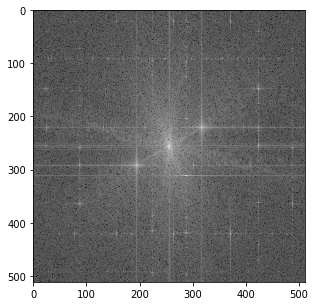

In [7]:
GraficarFourierShift(fxy)

Los pares a tratar serán:
 1. $(315, 220)$ con radio de corte $0.017$.
 2. $(225, 200)$ con radio de corte $0.018$.

In [8]:
img_out, img_ruido = FiltroDeRecorte(img=fxy, coordenadas=((315,220),(225,200)), d0=(0.017,0.018))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd63fe7c908>,
 Text(0.5,1,'Ruido'))

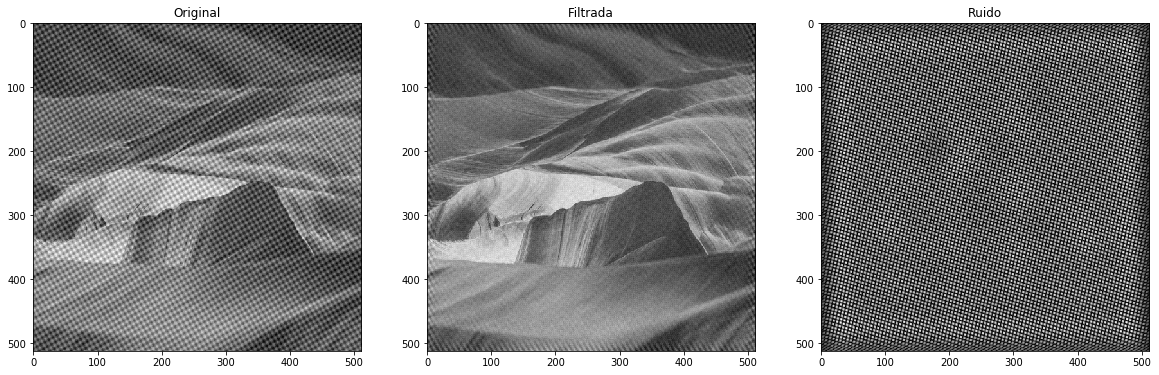

In [9]:
figure(figsize=(20, 20))
plt.subplot(131),plt.imshow(fxy, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(img_out, 'gray'),plt.title('Filtrada')
plt.subplot(133),plt.imshow(img_ruido, 'gray'),plt.title('Ruido')

### Imagen 2

In [10]:
# Leer imagen original
fxy = PrepararImagen('2.png')

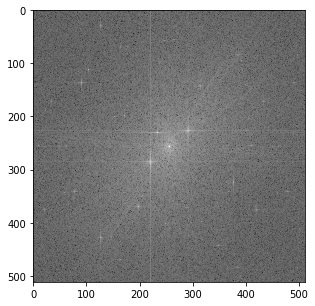

In [11]:
GraficarFourierShift(fxy)

Los pares a tratar serán:
 1. $(220,287)$ con radio de corte $0.015$.
 2. $(235,230)$ con radio de corte $0.01$.

In [12]:
img_out, img_ruido = FiltroDeRecorte(img=fxy, coordenadas=((220,287),(235,230)), d0=(0.015,0.01))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5c86ab9e8>,
 Text(0.5,1,'Ruido'))

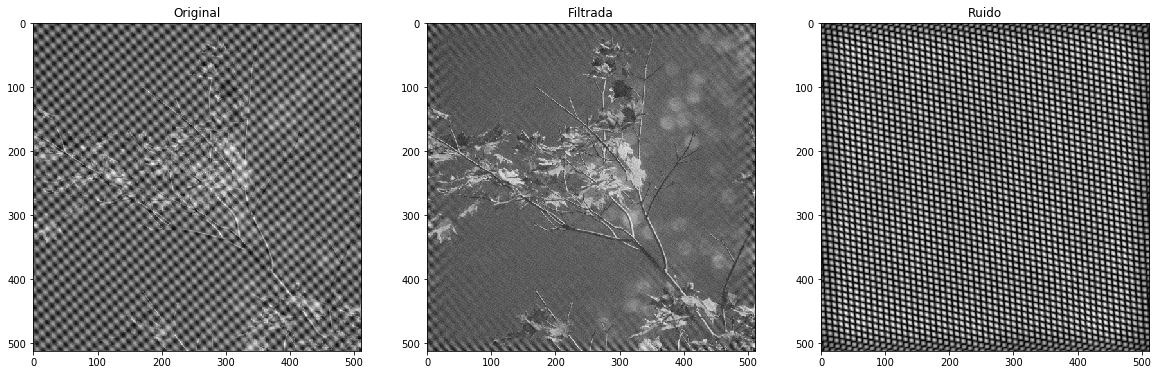

In [13]:
figure(figsize=(20, 20))
plt.subplot(131),plt.imshow(fxy, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(img_out, 'gray'),plt.title('Filtrada')
plt.subplot(133),plt.imshow(img_ruido, 'gray'),plt.title('Ruido')

### Imagen 3

In [14]:
# Leer imagen original
fxy = PrepararImagen('3.png')

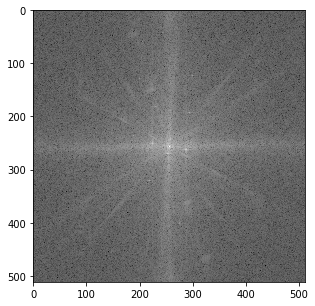

In [15]:
GraficarFourierShift(fxy)

Los pares a tratar serán:
 1. $(225, 250)$ con radio de corte $0.01$.
 2. $(260, 240)$ con radio de corte $0.008$.

In [16]:
img_out, img_ruido = FiltroDeRecorte(img=fxy, coordenadas=((225,250),(260,240)), d0=(0.01,0.008))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5c8583c18>,
 Text(0.5,1,'Ruido'))

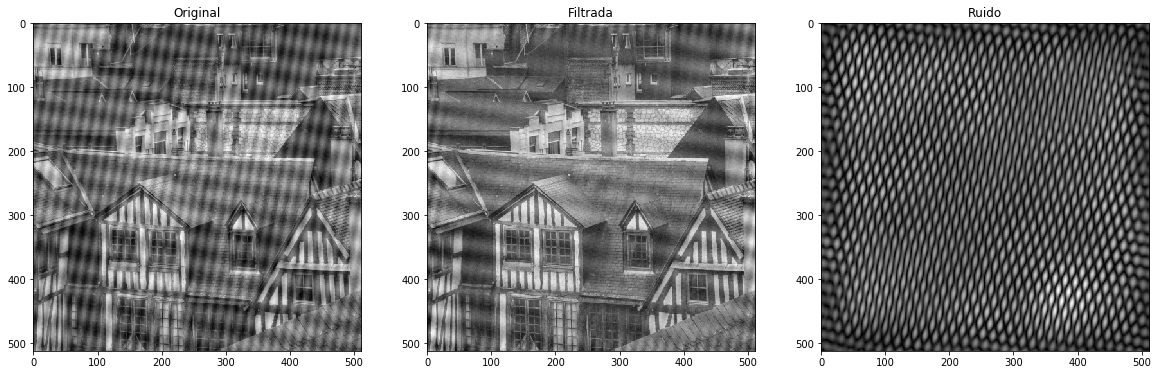

In [17]:
figure(figsize=(20, 20))
plt.subplot(131),plt.imshow(fxy, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(img_out, 'gray'),plt.title('Filtrada')
plt.subplot(133),plt.imshow(img_ruido, 'gray'),plt.title('Ruido')

### Imagen 4

In [18]:
# Leer imagen original
fxy = PrepararImagen('4.png')

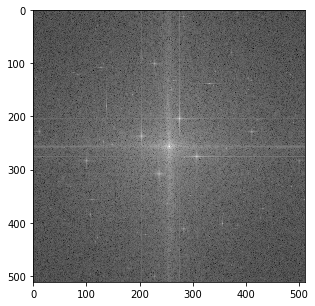

In [19]:
GraficarFourierShift(fxy)

Los pares a tratar serán:
 1. $(276, 203)$ con radio de corte $0.022$.
 2. $(203, 236)$ con radio de corte $0.013$.

In [20]:
img_out, img_ruido = FiltroDeRecorte(img=fxy, coordenadas=((276,203),(203,236)), d0=(0.022,0.013))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5c00bce10>,
 Text(0.5,1,'Ruido'))

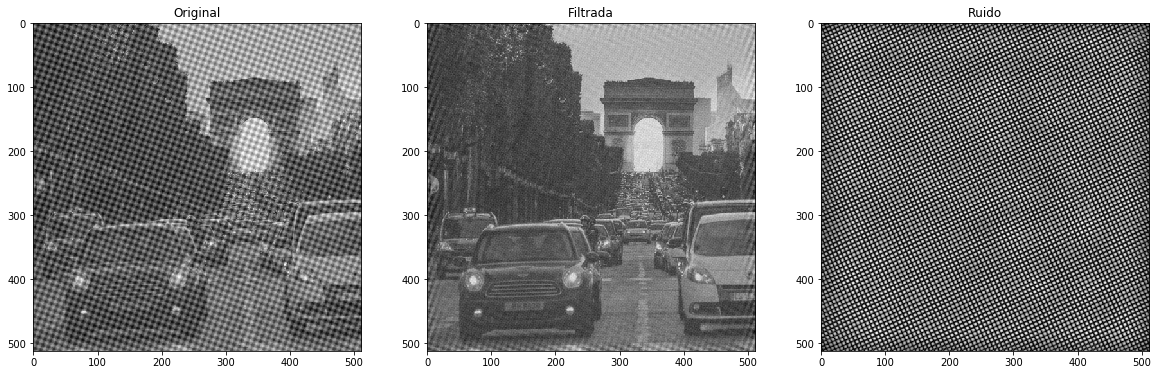

In [21]:
figure(figsize=(20, 20))
plt.subplot(131),plt.imshow(fxy, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(img_out, 'gray'),plt.title('Filtrada')
plt.subplot(133),plt.imshow(img_ruido, 'gray'),plt.title('Ruido')

### Imagen 5 (el más difícil)

In [22]:
# Leer imagen original
fxy = PrepararImagen('5.png')

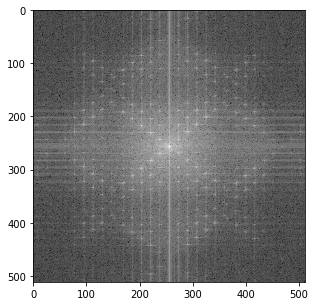

In [23]:
GraficarFourierShift(fxy)

Los pares a tratar serán:
 1. $(271, 241)$ con radio de corte $0.021$.
 2. $(291, 281)$ con radio de corte $0.012$.

In [24]:
img_out, img_ruido = FiltroDeRecorte(img=fxy, coordenadas=((271,241),(291,281)), d0=(0.012,0.012))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd5c882fdd8>,
 Text(0.5,1,'Ruido'))

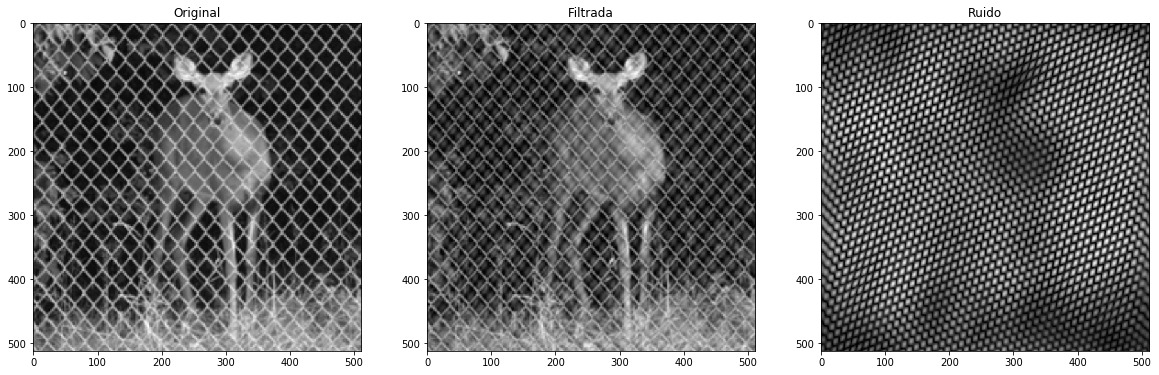

In [25]:
figure(figsize=(20, 20))
plt.subplot(131),plt.imshow(fxy, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(img_out, 'gray'),plt.title('Filtrada')
plt.subplot(133),plt.imshow(img_ruido, 'gray'),plt.title('Ruido')

## Imagen extra que se me ocurrió de una foto de un Tamagotchi obtenida de Twitter [2]

"El Tamagotchi es un aparato electrónico con la forma y el tamaño de un huevo, que tiene una pantalla en blanco y negro pixelada, donde se puede ver a la mascota virtual" [3]

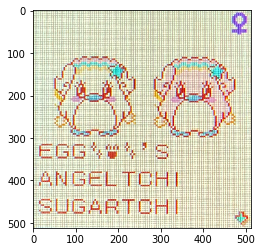

In [74]:
fxy = cv2.imread('tamagotchi.jpeg')
numFilas = 512
numCols = 512
# Escalar la imagen a múltiplos de 2
fxy = cv2.resize(fxy, (numCols, numFilas))
plt.imshow(fxy, 'gray')

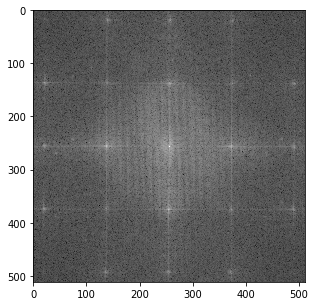

In [89]:
GraficarFourierShift(fxy[:,:,0])

Hacer el filtrado en cada capa de color de la imagen

In [107]:
aux_img = copy(fxy)
for i in range(3):
    aux_img[:,:,i], img_ruido = FiltroDeRecorte(img=fxy[:,:,i], coordenadas=((256,138),(138,256)), d0=(0.015,0.015))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd58c777208>,
 Text(0.5,1,'Ruido'))

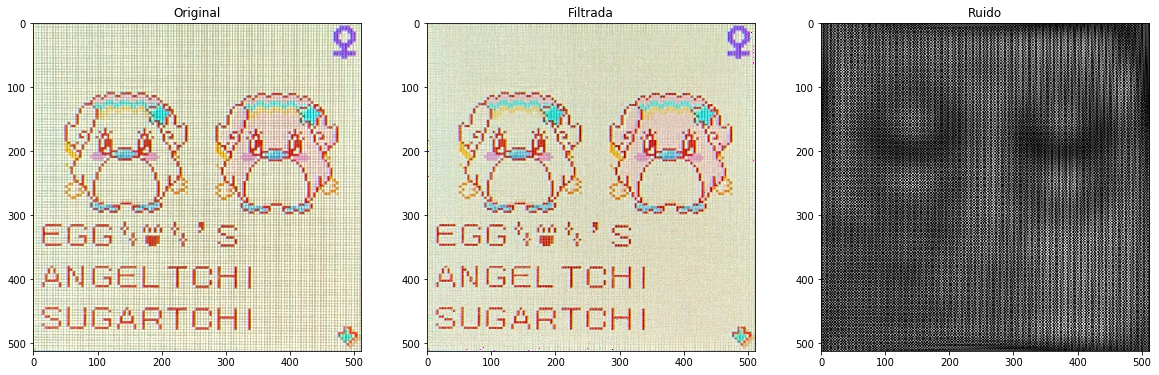

In [108]:
figure(figsize=(20, 20))
plt.subplot(131),plt.imshow(fxy, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(aux_img, 'gray'),plt.title('Filtrada')
plt.subplot(133),plt.imshow(img_ruido, 'gray'),plt.title('Ruido')

Funciona para desaparecer el contorno los pixeles del cuadriculado sin mucha pérdida de información. Si se aumenta el radio de recorte disminuye el ruido y no se pierde mucha información.

# Conclusiones

1. La imagen del _deer_ es rara ya que no es ruido agregado a la imagen (sea manualmente o por defectos o default cámara) y es parte de la imagen lo cual lo hace difícil de quitar con solo 2 pares de puntos, porque como se puede ver en su imagen de transformada de fourier, son demasiados los puntos con frecuencia que se deben anular.

2. Al no eliminarse todos los puntos que son problema en las frecuencias, se conserva un poco de ruido en las orillas de las imégenes pero es lo suficiente para reconocer lo que está en la imagen como en la imagen 2. 

3. Me compliqué al no hacer la tarea pero en realidad resultó ser fácil, lo unico que cambió a lo hecho en clase fue la forma en la cual se calculan las distancias ya que ahora se mueven del centro, pero todo lo demás se queda igual. Admito que fue mi error no poder entender las imágenes de salida que obtenía en la versión anterior, ya que el problema era que no estaban el rango de [0,250], ahora me doy cuenta que debo prestar más atención a esos detalles.

4. Quiero dejar en claro la increíble satisfacción que es ver una imagen sin ruido.

# Referencias

1. (2021). [Image]. Accesado de https://twitter.com/tamagotzu/status/1347240971130515458?s=19
2. Serie de Fourier. Accesado el  8 de enero de 2021, de https://es.wikipedia.org/wiki/Serie_de_Fourier
3. Tamagotchi. Accesado el  8 de enero de 2021, de https://es.wikipedia.org/wiki/Tamagotchi